In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import lightgbm as lgb

In [49]:
data = pd.read_csv('../data/stock_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
cutoff_date = '2023-09-01'
cutoff_date = pd.to_datetime(cutoff_date)
stock_data = data[data['Date'] <= cutoff_date]
future_data = data[data['Date'] > cutoff_date]

In [50]:
X = stock_data.drop(columns=['Date', 'Adj Close']).fillna(method='ffill').fillna(method='bfill')
y = stock_data['Adj Close'].fillna(method='ffill').fillna(method='bfill')

In [51]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [52]:
ensemble_model = VotingRegressor(
    estimators=[
        ('lgb', lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=100)),
        ('xgb', XGBRegressor(n_estimators=100)),
        ('lr', LinearRegression()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('svr', SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))
    ],
    weights=[0.4, 0.4, 0.05, 0.1, 0.05]  # Adjust weights as necessary
)
ensemble_model.fit(X_scaled, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 1427, number of used features: 17
[LightGBM] [Info] Start training from score 104.472017


VotingRegressor(estimators=[('lgb', LGBMRegressor(learning_rate=0.05)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=100,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=None, ...)),
                            ('lr', LinearRegression()),
                            ('rf', RandomForestRegressor(random_state=42)),
                            ('svr', SVR(C=100, gamma=0.1))],
                weights=[0.4, 0.4, 0.05, 0.1, 0.05])

In [53]:
last_row = X_scaled[-1:]
future_days = 10
future_features = np.tile(last_row, (future_days, 1))

# Slightly modify these features to simulate change over time
np.random.seed(42)  # Ensure reproducibility
variation = np.random.normal(0, 0.01, future_features.shape)  # Small changes
future_features += variation

# Predict the 'Adj Close' for the next 10 days
predicted_prices = ensemble_model.predict(future_features)

predicted_prices

array([190.12030503, 190.05675701, 190.28623066, 189.19113293,
       190.09053762, 188.08427028, 189.32267184, 190.57109193,
       188.12806592, 190.12067962])

In [54]:
actual_prices = future_data['Adj Close'][:10]
dates = future_data['Date'][:10]

In [55]:
data = pd.DataFrame({
    'Date': dates,
    'actual price': actual_prices,
    'predicted price': predicted_prices
})

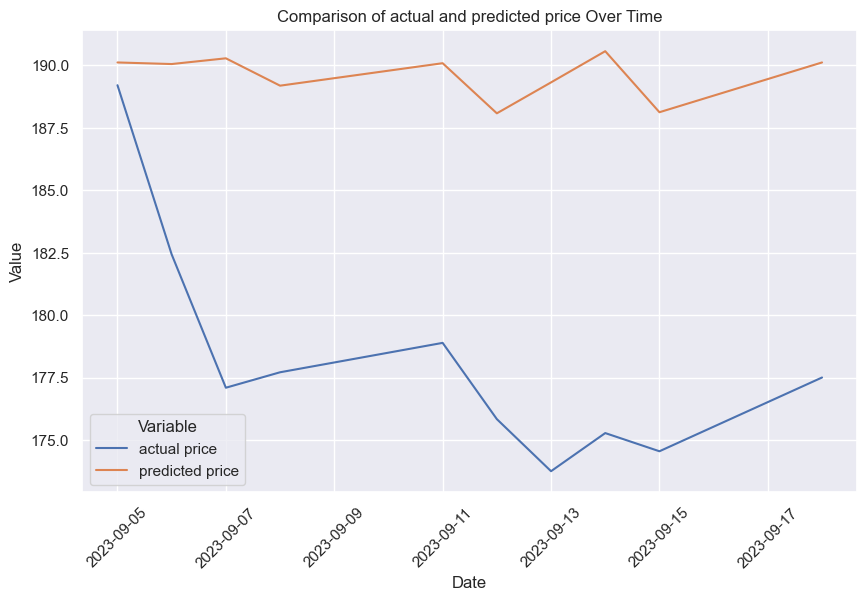

In [56]:
data_long = pd.melt(data, id_vars=['Date'], value_vars=['actual price', 'predicted price'], var_name='Variable', value_name='Value')

# Create the plot
sns.set_theme()  # Set the Seaborn theme
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the data using seaborn lineplot
sns.lineplot(data=data_long, x='Date', y='Value', hue='Variable')

# Customize the plot
plt.title('Comparison of actual and predicted price Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the plot
plt.show()
